[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LHCfitNikhef/EELSfitter/blob/documentation/tutorials/tutorial_eelsfitter.ipynb)

# EELSfitter tutorial

In this tutorial, we are going to train a model of the zero-loss peak (ZLP) background of polytopic WS$_2$ nanoflowers. Individiual spectra are first classified as a function of the integrated intensity, which serves as a direct measure of the local thickness, with $K$-means clustering before serving as input to a feedforward neural network. 

The ZLP models can be used to obtain a ZLP-subtracted spectral image (SI), which in turn can be used for quantification such as calculating the local thickness, perform Kramers-Krönig analysis to obtain the dielectric function or fit the onset to determine the band gap energy of the materials if applicable.

## Installing EELSfitter

To install EELSFitter, if not done already, one should run the following command.

In [ ]:
!pip install EELSFitter

This is a necessary step if one chooses to run from google colab. This step
can be skipped if one is running locally and EELSFitter has already been installed. Please make sure you have the latest version of EELSFitter installed (currently at 3.1.0).

Additionally for this tutorial make sure to install wget, as we need to download some files from the EELSFitter repository.

In [ ]:
!pip install wget

## Loading the SI

First of all, let us import the EELSFitter package:

In [3]:
import os
import numpy as np
import wget

import EELSFitter as ef
from EELSFitter.plotting.zlp import plot_zlp_per_pixel, plot_zlp_per_cluster
from EELSFitter.plotting.heatmaps import plot_heatmap

from matplotlib import rc

# If you want to use LaTeX for typesetting, use this.
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=True)

Next, we download and load the spectral image and specify the location where we would like to store our output, such as plots.

In [4]:
dm4_url='https://github.com/LHCfitNikhef/EELSfitter/blob/documentation/tutorials/area03-eels-SI-aligned.dm4?raw=true'
wget.download(dm4_url)

'area03-eels-SI-aligned.dm4'

In [5]:
path_to_image = "area03-eels-SI-aligned.dm4"
im = ef.SpectralImage.load_dmfile(path_to_image)
im.output_path = os.path.join(os.getcwd(), 'output\\')

if not os.path.exists(im.output_path):
    os.mkdir(im.output_path)

In case the metadata doesn't contain the correct information (as with this data file), run the following cell to put the correct beam energy, collection angle and convergence angle.

In [6]:
im.beam_energy = 200            # KeV
im.collection_angle = 67.2      # mrad
im.convergence_angle = 67.2     # mrad

The below specifies some of our plot settings:

In [7]:
# Colormap
cmap="coolwarm"

# Title and save location settings
title_specimen = r'$\rm{WS_2\;nanoflower\;}$'
save_title_specimen = 'WS2_nanoflower'
save_loc = im.output_path

## Visualising the SI

With the spectral image loaded, we can take a first look at what our image actually looks like. We decide to produce a heatmap of the integrated intensity, which is a measure of the local thickness.

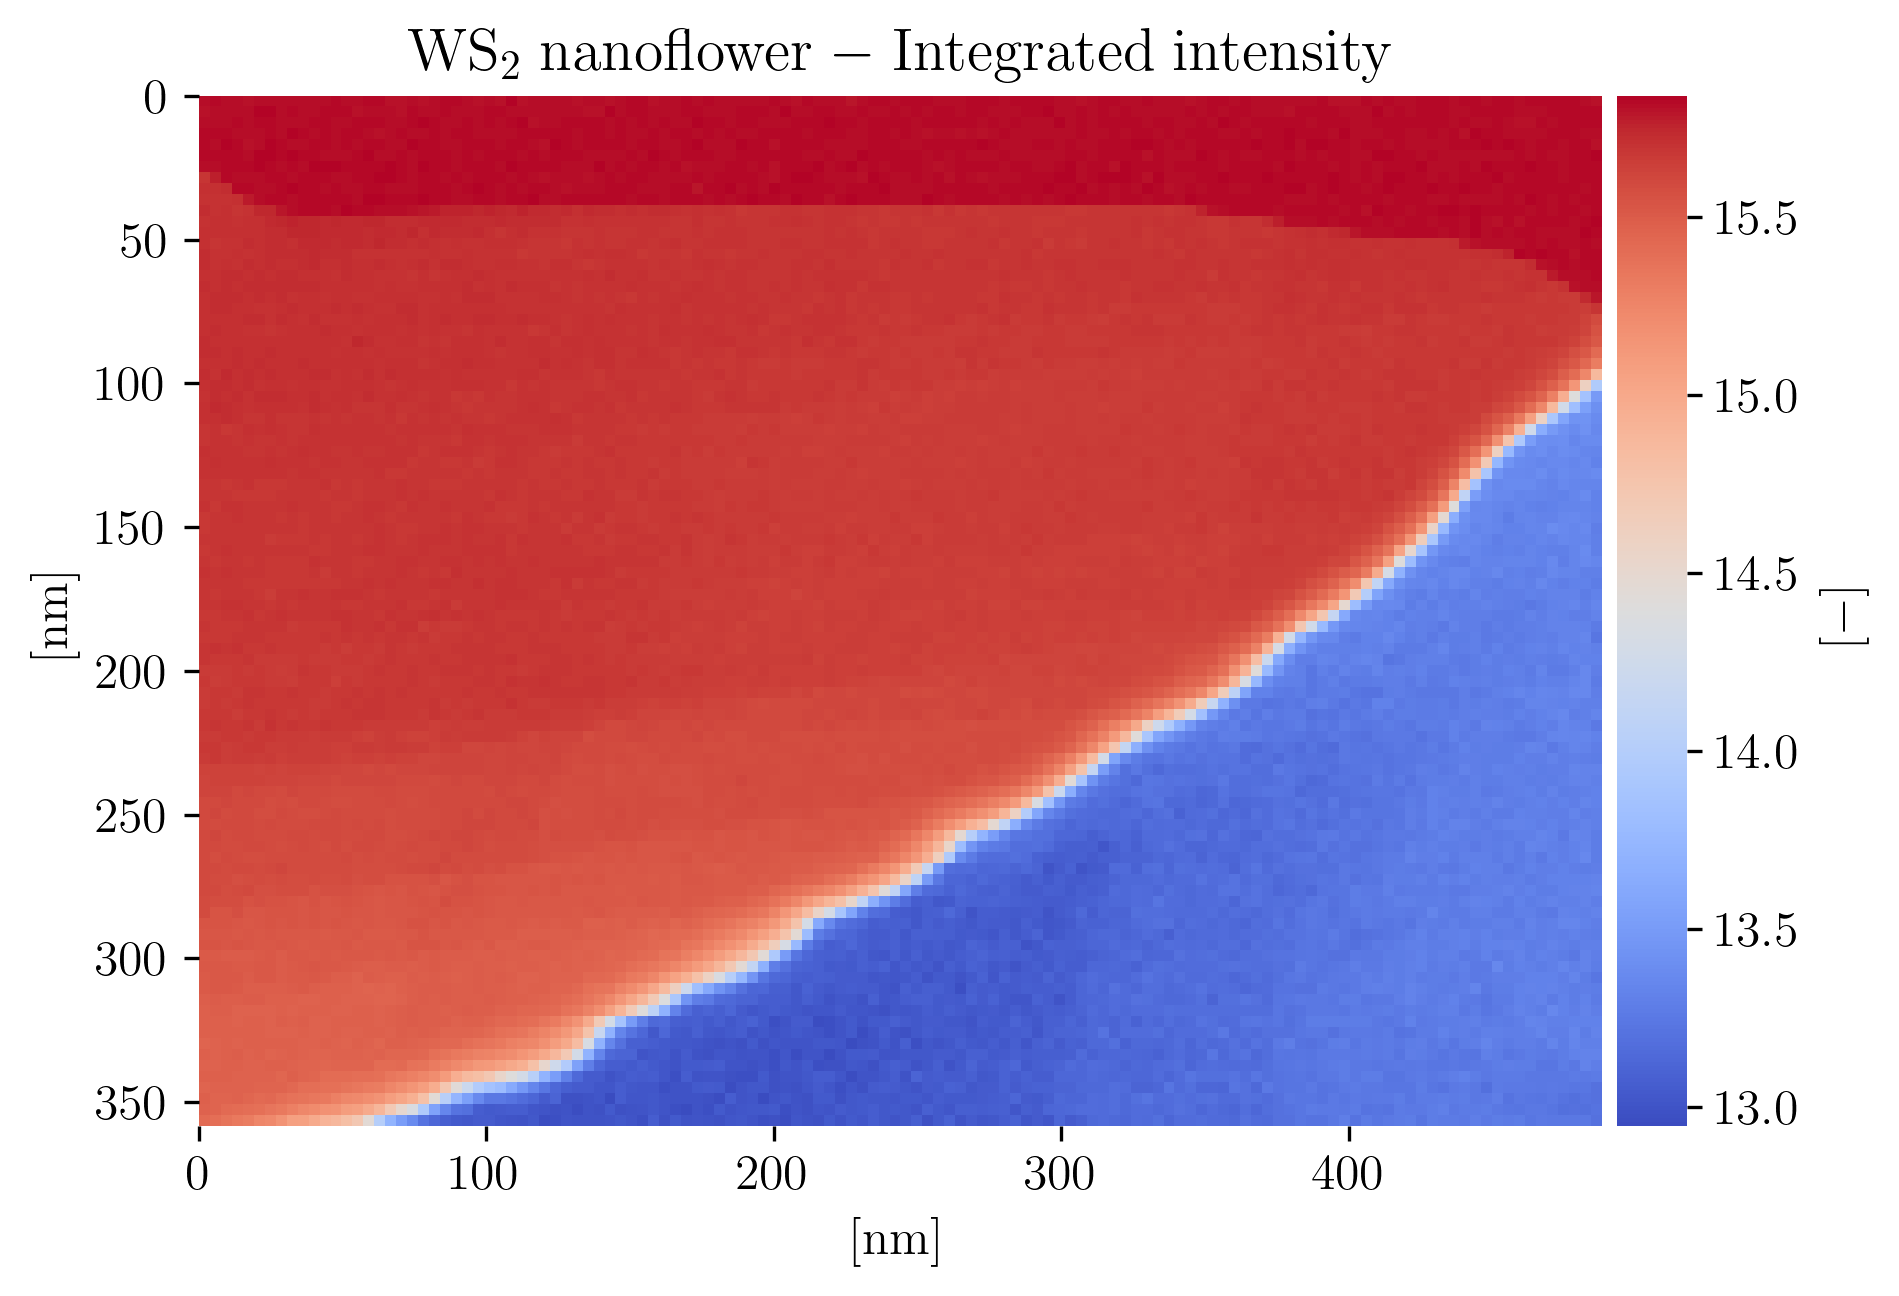

In [8]:
intensity = np.log(np.sum(im.data, axis=2))
hmap = plot_heatmap(image=im, dpi=300,
                    data=intensity, 
                    title=title_specimen + r'$\rm{-\;Integrated\;intensity\;}$',
                    cbarlabel=r"$\rm{[-]}$", 
                    cmap=cmap)
hmap.savefig(save_loc + save_title_specimen + '_Integrated_Intensity.png',
             bbox_inches='tight', transparent=True)

## Clustering

Since the ZLP intensity depends strongly on the local thickness of the specimen, first of all we group individual spectra as a function of their thickness by means of unsupervised machine learning, specifically by means of the K-means clustering algorithm: 

In [10]:
n_clusters = 5
based_on = 'log_zlp'
seed = 12345678
im.cluster(n_clusters=n_clusters, based_on=based_on, seed=seed)

Seed: 12345678 finished after 11 iterations and has cost: 283.9922123911442
Seed: 12345678 has the lowest cost
cluster centroids are [13.8523058  13.50187578 13.04870563 11.5047533   9.21580891]
# of spectra per cluster is [1419 6001 1194  209 3209]


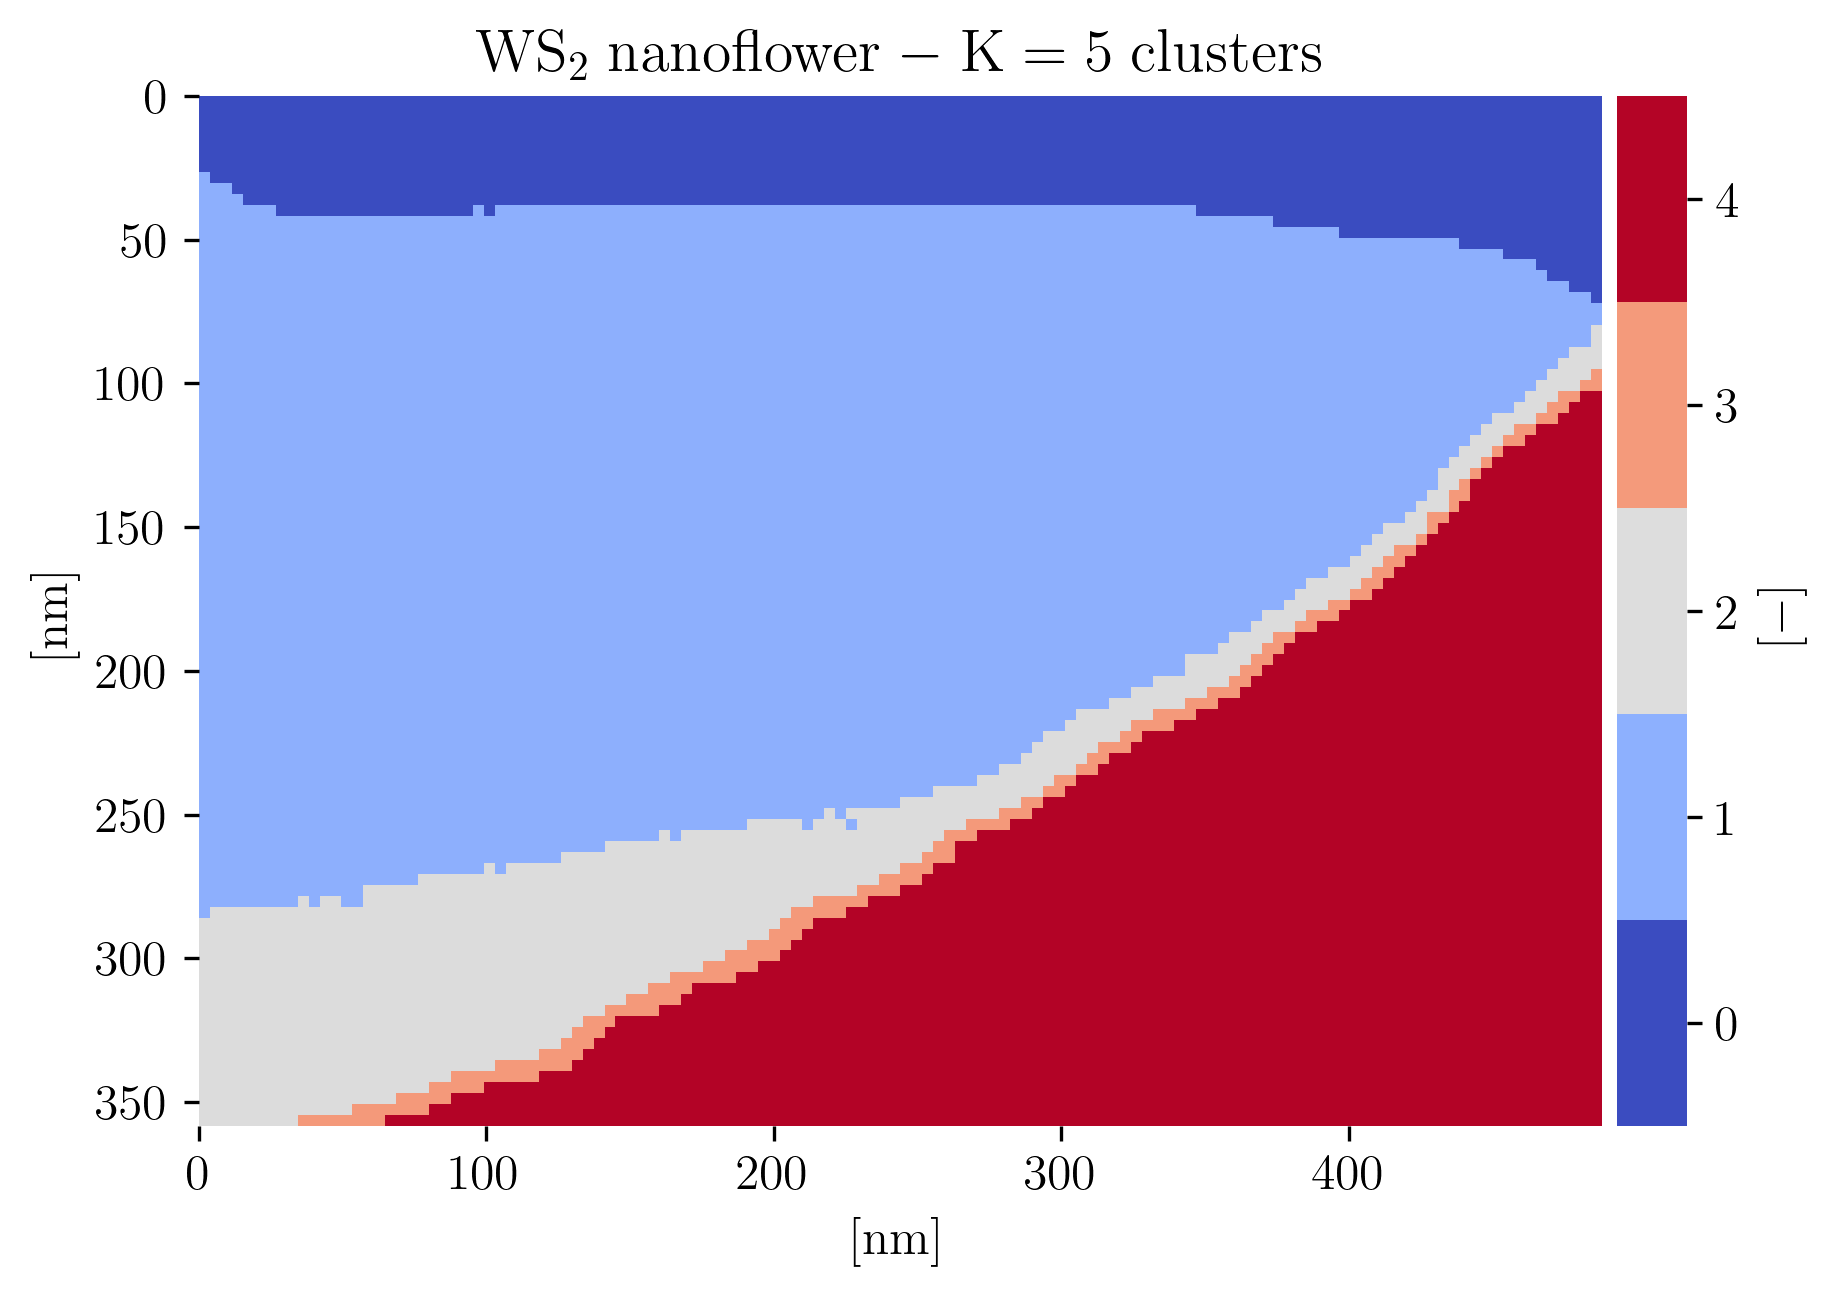

In [11]:
hmap = plot_heatmap(image=im, dpi=300,
                    data=im.cluster_labels, 
                    title=title_specimen +  r'$\rm{-\;K=%d\;clusters\;}$' % n_clusters,
                    cbarlabel=r"$\rm{[-]}$", cmap=cmap, discrete_colormap=True)
hmap.savefig(save_loc + save_title_specimen + '_Clustered.png',
             bbox_inches='tight', transparent=True)

## Training of the ZLP

The ZLP can be trained with the following lines of code. It produces a couple of plots:
1.  The raw signal per cluster, including the position of the hyperparamter $E_I$
2.  The slow of the raw signal per cluster
3.  The value of the loss per epoch on both training and validation set

The more replicas one uses to train the ZLP, the more accurate the model becomes.

In [ ]:
n_replica = 1                   # number of replicas
n_epochs = 1000                 # number of epochs
regularisation_constant = 1.    # Penalty term to prevent models from going up in region II, set to 0 to disable. This will increase training time significantly if enabled.
display_step = 200              # show training report after display_step steps

# Choose to shift the hyperparameters a bit
shift_dE1 = 1.
shift_dE2 = 1.

signal_type = 'EELS'

path_to_models = os.path.join(im.output_path, "models") # where to store the trained models
if not os.path.exists(path_to_models):
    os.mkdir(path_to_models)

im.train_zlp_models(n_clusters=n_clusters,
                    seed=seed,
                    based_on=based_on,
                    n_replica=n_replica,
                    n_epochs=n_epochs,
                    shift_de1=shift_dE1,
                    shift_de2=shift_dE2,
                    regularisation_constant=regularisation_constant,
                    display_step=display_step,
                    path_to_models=path_to_models,
                    signal_type=signal_type)

fig1 = im.train_zlps.plot_hp_cluster(title=r'$\rm{Position\;of\;dE1\;\&\;dE2\;per\;cluster\;}$',
                                     xlabel=r'$\rm{Energy\;loss\;[eV]\;}$',
                                     ylabel=r'$\rm{Intensity\;[a.u.]\;}$',
                                     xlim=[0, 10],
                                     ylim=[10, 1e4],
                                     yscale='log')

fig2 = im.train_zlps.plot_hp_cluster_slope(title=r'$\rm{Position\;of\;dE1\;\&\;dE2\;per\;slope\;of\;cluster\;}$',
                                           xlabel=r'$\rm{Energy\;loss\;[eV]\;}$',
                                           ylabel=r'$\rm{dI/dE\;[a.u.]\;}$',
                                           xlim=[0, 10],
                                           ylim=[-1e3, 1e3])

Since the actual training time that is needed to obtain a fair amount of models (~1000) takes a couple of hours, we provide a set of *pretrained* models to experiment with. We will use these in what follows. 

They can be downloaded by

In [ ]:
url = 'https://github.com/LHCfitNikhef/EELSfitter/blob/documentation/Models/tutorial/models_ws2_E1_s09_E2_s1_k5_r10.zip?raw=true'
wget.download(url)

In [ ]:
!unzip models_E1_p16_k5.zip

In [20]:
path_to_pretrained_models = os.path.join(os.getcwd(), "E1_s09_E2_s1_k5_r10")

## Training report

The pretaind models have now been downloaded, so let us see what they look like. The cell immediately below loads the models, plots the cost distribution on the training and validation sets and plots how the predicted ZLPs behave as a function of the total integrated intensity per cluster:

In [ ]:
im.load_zlp_models(path_to_models=path_to_pretrained_models, based_on='log_zlp', plot_chi2=True, plot_pred=True)

This shows that the clustering has been effective, since the ZLPs do not overlap before $E_I$. Let us consider a specific pixel, say (30, 90), to see how the subtracted spectrum compares to the raw spectrum.

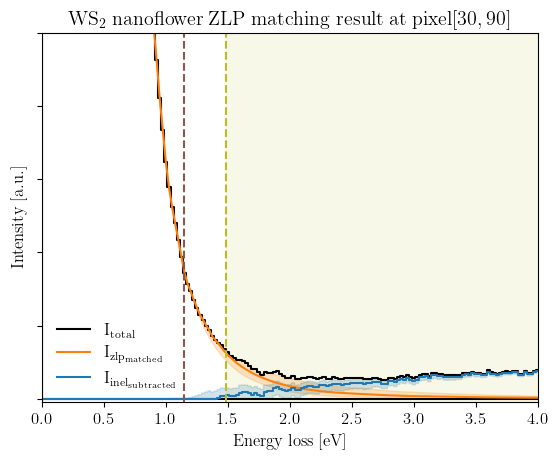

In [22]:
pixx = 30
pixy = 90
signal_type = 'pool'

fig = plot_zlp_per_pixel(im, pixx, pixy, signal_type=signal_type,
                          zlp_gen=False, zlp_match=True,
                          subtract=True, deconv=False,
                          hyper_par=True, random_zlp=None,
                          title=title_specimen + r"$\rm{ZLP\;matching\;result\;at\;pixel[%d,%d]}$" % (pixx, pixy),
                          xlabel=r"$\rm{Energy\;loss\;[eV]}$", ylabel=r"$\rm{Intensity\;[a.u.]}$",
                          xlim=[0, -1*im.eaxis[0]], ylim=[-10, 1e3])

We conclude this tutorial by plotting, for each cluster, the raw signal plus the ZLP with uncertainties evaluated at the cluster means:

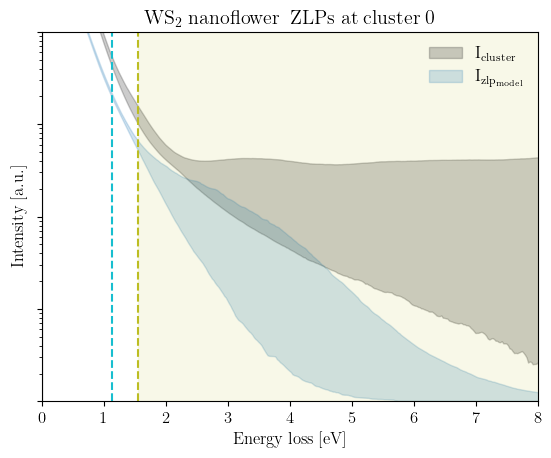

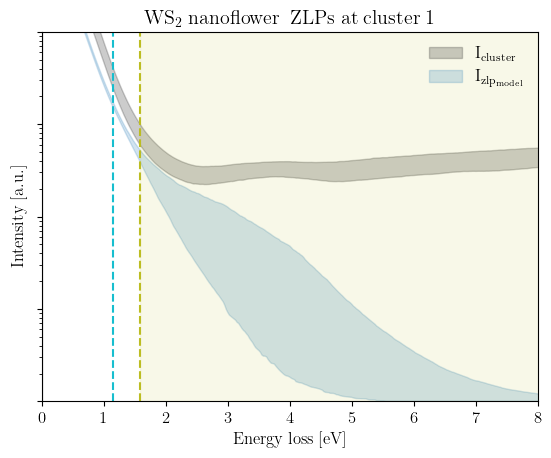

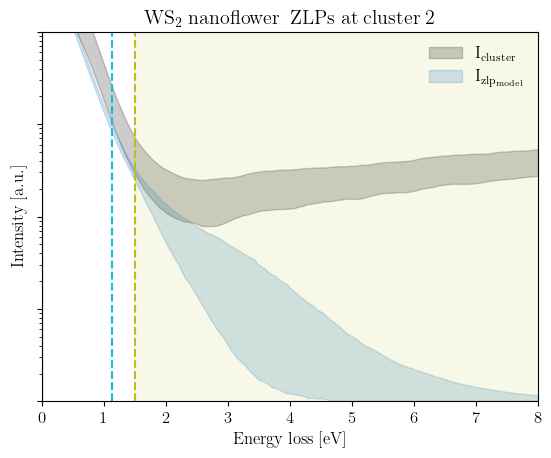

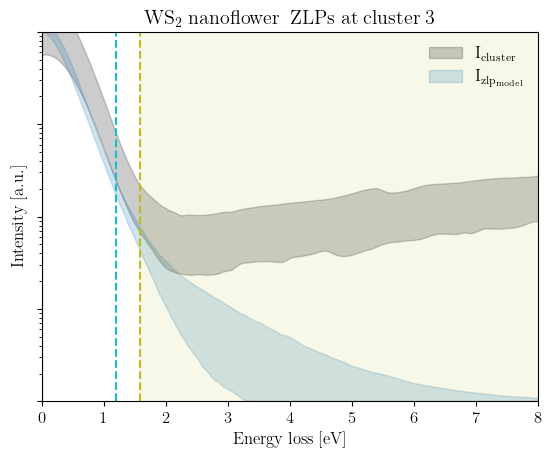

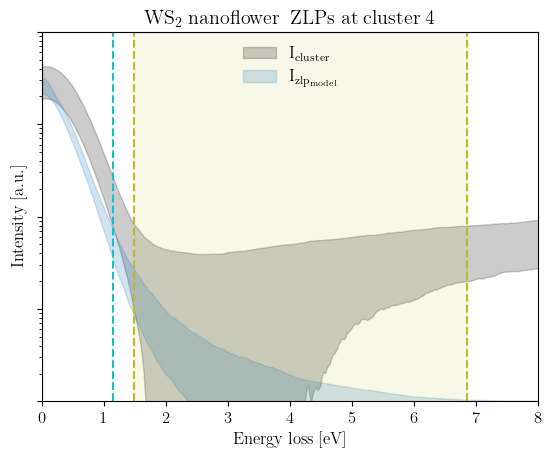

In [23]:
signal_type = 'EELS'
for cluster, centroid in enumerate(im.cluster_centroids):
    fig = plot_zlp_per_cluster(im, cluster=cluster, signal_type=signal_type,
                               zlp_gen=True, hyper_par=True, smooth=True,
                               title=title_specimen + r"$\rm{\;ZLPs\;at\;cluster\;%d}$" % cluster,
                               xlabel=r"$\rm{Energy\;loss\;[eV]}$", ylabel=r"$\rm{Intensity\;[a.u.]}$",
                               yscale='log',
                               xlim=[0, -2*im.eaxis[0]], ylim=[1, 1e4])